In [7]:
!wget https://lodmedia.hb.bizmrg.com/case_files/1128664/train_dataset_cold_start_train.zip

--2024-09-28 11:25:15--  https://lodmedia.hb.bizmrg.com/case_files/1128664/train_dataset_cold_start_train.zip
Resolving lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)... 95.163.53.117
Connecting to lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)|95.163.53.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4477652786 (4.2G) [application/zip]
Saving to: ‘train_dataset_cold_start_train.zip’

train_dataset_cold_ 100%[===================>]   4.17G  42.6MB/s    in 94s     

2024-09-28 11:26:50 (45.3 MB/s) - ‘train_dataset_cold_start_train.zip’ saved [4477652786/4477652786]



In [ ]:
# ВНИМАНИЕ!



In [9]:
!unzip train_dataset_cold_start_train.zip

Archive:  train_dataset_cold_start_train.zip
  inflating: logs_df_2024-08-05.parquet  
  inflating: logs_df_2024-08-06.parquet  
  inflating: video_stat.parquet      
  inflating: Состав датасета.docx  


In [16]:
!ls

 BaseFlow.ipynb   environments	 train_dataset_cold_start_train.zip
 data_files	  setup.sh	'Состав датасета.docx'


In [15]:
!mv video_stat.parquet ./data_files/video_stat.parquet

In [1]:
import os
import psutil
from __future__ import print_function

pid = os.getpid()
python_process = psutil.Process(pid)
memoryUse = python_process.memory_info()[0]/2.**30  # memory use in GB...I think
print('memory use:', memoryUse, 'GB')
print('cpu % used:', psutil.cpu_percent())
print('memory % used:', psutil.virtual_memory()[2])

memory use: 0.056674957275390625 GB
cpu % used: 1.0
memory % used: 10.7


# Data Preapre

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [12]:
df = pd.read_parquet('./data_files/logs_df_2024-08-05.parquet', engine='pyarrow')

In [41]:
users = df['user_id'].unique()[:20000]
df = df[df['user_id'].isin(users)]

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 861406 entries, 0 to 34453365
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype                                
---  ------           --------------   -----                                
 0   event_timestamp  861406 non-null  datetime64[ms, pytz.FixedOffset(180)]
 1   user_id          861406 non-null  object                               
 2   region           861406 non-null  object                               
 3   city             861406 non-null  object                               
 4   video_id         540345 non-null  object                               
 5   watchtime        861406 non-null  int64                                
dtypes: datetime64[ms, pytz.FixedOffset(180)](1), int64(1), object(4)
memory usage: 46.0+ MB


In [15]:
df_video = pd.read_parquet('./data_files/video_stat.parquet', engine='pyarrow')

In [43]:
df_video = df_video[df_video['video_id'].isin(df['video_id'].unique())]

In [44]:
all_data = pd.merge(df, df_video, how='inner', left_on='video_id', right_on='video_id')

In [45]:
def create_long_watch(row):
  if row['v_duration'] <= 300 and row['watchtime'] >= 30:
    return True
  elif row['watchtime'] >= row['v_duration'] * 0.25:
    return True
  return False


all_data['long_watch'] = all_data[['watchtime', 'v_duration']].apply(lambda row: create_long_watch(row), axis=1)

# Test top@k

Начнем с исследования разнообразных примитивных подходов к решению проблемы холодного старта.

In [46]:
split = int(len(users) * 0.8)
users_train = users[:split]
users_test = users[split:]

print(f'train shape: {users_train.shape}')
print(f'test shape: {users_test.shape}')

train shape: (16000,)
test shape: (4000,)


In [47]:
df_train = all_data[all_data['user_id'].isin(users_train)]
df_test = all_data[all_data['user_id'].isin(users_test)]

In [48]:
df_test = df_test[df_test['long_watch'] == 1]
df_tesdf_test = df_test.groupby('user_id')['video_id'].apply(list)

# Метрики

## Hit rate

Отображает факт: есть наш фильм в списках пользователя или нет

In [24]:
def hit_rate(pred, df_true):
    count_ok = 0
    for i, (_, val) in enumerate(df_true.items()):
        predict = pred[i]
        for p in predict:
            if p in val:
                count_ok += 1
                break
    return count_ok / len(df_true)

## Precision
Учитывает % видео среди предсказанных, которые были в списке любимых у пользователя

In [25]:
def precision_rate(pred, df_true):
    count_ok = 0
    for i, (_, val) in enumerate(df_true.items()):
        current_count = 0
        predict = pred[i]
        for p in predict:
            if p in val:
                current_count += 1
        count_ok += current_count / len(predict)
    return count_ok / len(df_true)

# Top @10 k

## Стратегия по наиболее популярным

In [39]:
K=10
popular_videos = df_train.groupby('video_id').first().nlargest(K, 'v_year_views').index.values

# Пример релевантных видео для пользователя
pred = [popular_videos for _ in range(len(df_test))]

print(f'Hit-rate: {round(hit_rate(pred, df_test), 4)}')
print(f'Precision-rate: {round(precision_rate(pred, df_test), 4)}')

Hit-rate: 0.0502
Precision-rate: 0.0083


## Топ по новизне¶

In [49]:
popular_videos = df_train.groupby('video_id').first().nlargest(K, 'v_pub_datetime').index.values

# Пример релевантных видео для пользователя
pred = [popular_videos for _ in range(len(df_test))]

print(f'Hit-rate: {round(hit_rate(pred, df_test), 4)}')
print(f'Precision-rate: {round(precision_rate(pred, df_test), 4)}')

Hit-rate: 0.0
Precision-rate: 0.0


## Топ по жинрам

In [56]:
genres = list(set(all_data['category_id'].values.tolist()))

import random

random.seed(42)


def predict(u_gen):
    popular_videos = df_train.groupby('video_id').first()
    popular_videos = popular_videos[popular_videos['category_id'].isin(u_gen)]
    popular_videos = popular_videos.nlargest(5, 'v_year_views').index.values
    return popular_videos

pred = []
for i, (_, val) in tqdm(enumerate(df_test.items())):
    u_genres = random.choices(genres, k=1)
    pred.append(predict(u_genres))

print(f'Hit-rate: {round(hit_rate(pred, df_test), 4)}')
print(f'Precision-rate: {round(precision_rate(pred, df_test), 4)}')

Hit-rate: 0.1342
Precision-rate: 0.0333


In [ ]:
from sklearn.cluster import KMeans

random.seed(42)
kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")

df_train_knn = df_train.copy()
df_train_knn = df_train_knn.groupby('user_id').count()
# df_train_knn['rating'] = df_train.groupby('user_id')['rating'].mean()
df_train_knn['long_watch'] = df_train.groupby('user_id')['long_watch'].mean()
df_train_knn['popularity'] = df_train.groupby('user_id')['v_year_views'].mean()


kmeans.fit(df_train_knn)
df_train_knn['all_labels'] = kmeans.labels_

df_train['knn_label'] = df_train['user_id'].apply(lambda row: df_train_knn.loc[row]['all_labels'])

pred = []
for i, (_, val) in enumerate(df_test.items()):
    u_k = random.choice([i for i in range(2)])
    pred.append(df_train[df_train['knn_label'] == u_k].groupby('video_id').first().nlargest(K, 'v_year_views').index.values)

print(f'Hit-rate: {hit_rate(pred, df_test)}')
print(f'Precision-rate: {precision_rate(pred, df_test)}')

# Модель ранжирования

начнем с подготовки данных. Преобразование категориальных признаков в числовые, создание ранжирования, и другие операции

In [8]:
# df_video.to_parquet('ColdStart/back/files/mvp_movie.parquet')

In [ ]:
all_data = pd.merge(df, df_video, how='inner', left_on='video_id', right_on='video_id')

In [9]:
all_data

,event_timestamp,user_id,region,city,video_id,watchtime,v_pub_datetime,v_total_comments,v_year_views,v_month_views,...,v_category_popularity_percent_7_days,v_category_popularity_percent_30_days,v_long_views_1_days,v_long_views_7_days,v_long_views_30_days,row_number,title,description,category_id,author_id
0,2024-08-05 12:12:32+03:00,bd1b6b07-e6a2-46ad-aa58-990bb7e89252,288eb079-1c29-4749-ab7e-550451a4d765,da903ff0-9eb8-4e91-b25d-22c70f962ca2,0af133e1-4fbf-4e10-b9e8-19fbe1a011c3,32,2024-02-20 20:54:19+03:00,0,1128,341,...,7.280147,7.123987,8,62,235,1,Сериал Чёрный список - 1 сезон 18 серия / The...,В 1 сезоне 18 серии сериала «Черный список» пр...,Сериалы,61a05a00-e54b-41f6-b876-b0908080f6ea
1,2024-08-05 18:30:15+03:00,7db026fc-b55c-4580-bc26-e3df59ba6c7c,f58ab76f-2581-447a-b95b-5832e8757054,8449a572-fd10-44ae-a899-af656e350ad9,4f42aab2-6238-4381-bb53-36213916e912,340,2024-07-08 13:07:53+03:00,7,61676,51113,...,7.201798,10.617716,0,1787,16866,1,Сериал Пацаны 4 сезон 1 серия / The Boys HDRezka,КИНО ВСЕГДА РЯДОМ - - ПОДПИСЫВАЙСЯ НА НАШ КАН...,Сериалы,439a1647-8a48-4a76-8d7d-64fcd3337038
2,2024-08-05 12:35:16+03:00,5c94a654-f376-4529-b463-b62b6b50e8ca,2c1f4ce4-66e0-4481-a0ed-244bf76fa83a,93a12888-fdf4-4889-a1ef-3ef0537d674d,8b106b84-f3f5-4c27-820c-7e1546b43614,12,2024-02-02 12:28:21+03:00,12,1274,144,...,1.283733,1.321895,0,27,63,1,РЖАВАЯ МОЛОДОСТЬ ИКАРУС 280,Календарь Ржавая Молодость 2024: За рубеж отпр...,Авто-мото,ec904301-2bf4-4ba9-80e5-2d741299f282
3,2024-08-05 20:48:51+03:00,b972399a-c4b9-47fe-88fa-ccb1827cd131,f28a922a-68b9-46ce-8b52-c0be09413514,a269faea-d63c-4196-9963-00c62b5b3264,305389f3-1c8d-4026-9eef-e2b875a35380,2460,2024-07-05 07:58:02+03:00,0,6382,6042,...,7.201798,10.617716,0,884,3743,1,Бесстыжие 3 сезон 7 серия «Долгий путь домой» ...,Фиона готовится к суду. Она полна решимости по...,Сериалы,716d6e15-8c45-4378-bf2e-d31f08cc30a4
4,2024-08-05 05:19:19+03:00,807fb9e8-0aac-4dd2-836b-48797681f4ff,09714619-66dc-4faa-acdf-b2ae9dd2549d,51c8f786-5661-4a9c-8ab2-5d52f31095de,caeb71a4-f0f6-4c6a-ac79-31bdbb58fef1,87,2024-04-15 18:36:25+03:00,0,15924,14291,...,5.271171,3.528815,0,6437,9043,1,"Паровозик Титипо, 1 сезон, 3 серия. Первый рей...",Наконец Титипо добирается до городка Чу-Чух.....,Мультфильмы,765e51ec-d74c-4c6e-b808-f294bf8be9ae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3286250,2024-08-05 05:44:12+03:00,723a6a92-2c62-4b4c-ae9f-01364bfba003,25b2e755-3e1c-42d3-999f-d9065d60b10f,b35d330f-8657-4965-b241-a4c534029447,09458a2d-eba1-4906-9fb9-f24284ba084a,413,2022-12-30 15:36:16+03:00,1,19273,1203,...,1.487207,1.458516,0,180,771,1,"Маша и Медведь, Сказка на ночь, 39 серия",Никогда Медведь не оставил бы Машу наедине с п...,Мультфильмы,f39f9031-d882-4234-920f-485e899bce90
3286251,2024-08-05 14:38:24+03:00,c8d49b58-a818-4e94-ab20-66c76522d64c,d2a0aecc-d3ee-442b-a3f6-6fbdf2ec4187,d32ecacd-fa43-49c1-a483-8a12873e07a4,c371d058-0474-42f7-b91a-b865b4db0075,61,2023-12-15 18:00:57+03:00,0,964,764,...,0.542671,0.664186,0,248,291,1,Аниме клип - Мой дикий сад,,Аниме,c8374eb1-ed7b-44d9-b1ce-5b00bd58ec35
3286252,2024-08-05 03:39:06+03:00,e8716a18-86d7-46b9-b521-a4af8b46de57,c11dc824-5ab7-4706-9c3e-f5c6a287b411,55da3018-5678-430f-9667-60bcca50d8ba,14a95335-6021-4cce-9d77-6233f7ff0fa5,171,2024-04-16 13:08:14+03:00,1,125,76,...,2.183451,2.416910,0,28,44,1,Анапа. Теплое море и жаркое солнце — идеальный...,Город-курорт Анапа расположенный на берегах Че...,Путешествия,edd32f11-bf6c-4bfe-a884-ae49a8565184
3286253,2024-08-05 13:16:19+03:00,3f28893d-09c0-4621-8223-3fcb49aa8c51,42608e8d-29bf-4f50-a7b7-e8813b470bfd,6b801afb-e4bf-4a08-b1a6-c239102d973f,29afcc47-2a36-4311-a657-7e5f87630b99,0,2024-04-19 13:55:38+03:00,161,617896,278306,...,20.665757,21.611320,0,23261,95619,1,Прямой эфир - ОТР,Общественное телевидение России (ОТР) - площад...,Телепередачи,642598f8-6852-489d-a5f0-59963c32210b


In [10]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(dtype=np.uint64)

all_data = all_data.drop(columns=['title', 'description'])
for col in ['region', 'city', 'category_id', 'author_id', 'user_id', 'video_id']:
    all_data[col] = oe.fit_transform(all_data[[col]])

In [11]:
all_data['event_timestamp'] = all_data['event_timestamp'].astype(int)
all_data['v_pub_datetime'] = all_data['v_pub_datetime'].astype(int)

In [12]:
def trim_to_top_3(group):
    return group.head(100)

# Применение функции к каждой группе, сгруппированной по user_id
all_data = all_data.groupby('user_id').apply(trim_to_top_3).reset_index(drop=True)

/tmp/ipykernel_109253/1144671415.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_data = all_data.groupby('user_id').apply(trim_to_top_3).reset_index(drop=True)


Создаем нашу собственную метрицу на основе глубины просмотра видео.

In [13]:
def create_rank(row):
    w = row['watchtime'] / row['v_duration']
    if w == 0:
        return 9
    elif 0 <= w < 0.1:
        return 8
    elif 0.1 <= w < 0.2:
        return 7
    elif 0.2 <= w < 0.3:
        return 6
    elif 0.3 <= w < 0.4:
        return 5
    elif 0.4 <= w < 0.5:
        return 4
    elif 0.5 <= w < 0.6:
        return 3
    elif 0.6 <= w < 0.7:
        return 2
    elif 0.7 <= w < 0.8:
        return 1
    return 0

all_data['rank'] = all_data[['watchtime', 'v_duration']].apply(lambda row: create_rank(row), axis=1)

/tmp/ipykernel_109253/1942594093.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  w = row['watchtime'] / row['v_duration']
/tmp/ipykernel_109253/1942594093.py:2: RuntimeWarning: invalid value encountered in scalar divide
  w = row['watchtime'] / row['v_duration']


In [14]:
all_data = all_data.drop(columns=['watchtime', 'event_timestamp'])
all_data = all_data.sort_values('user_id')

In [15]:
users = all_data['user_id'].unique()
split = int(len(users) * 0.8)
users_train = users[:split]
users_test = users[split:]

print(f'train shape: {users_train.shape}')
print(f'test shape: {users_test.shape}')

train shape: (150092,)
test shape: (37523,)


In [16]:
import lightgbm as lgb

df_train = all_data[all_data['user_id'].isin(users_train)]
df_test = all_data[all_data['user_id'].isin(users_test)]

qids_train = df_train.groupby("user_id")["user_id"].count().to_numpy()
X_train = df_train.drop(["user_id", "rank", 'video_id'], axis = 1)
y_train = df_train['rank'].astype(int)

qids_test = df_test.groupby("user_id")["user_id"].count().to_numpy()
X_test = df_test.drop(["user_id", "rank", 'video_id'], axis = 1)
y_test = df_test['rank'].astype(int)

In [17]:
ranker = lgb.LGBMRanker(
    objective='lambdarank',
    metric="map",
    n_estimators=100,
    random_state=4
)

gbm = ranker.fit(
      X=X_train,
      y=y_train,
      group=qids_train,
      eval_set=[(X_train, y_train),(X_test, y_test)],
      eval_group=[qids_train, qids_test],
      callbacks=[lgb.log_evaluation(10), lgb.early_stopping(50)],
      eval_at=[5, 10])

[LightGBM] [Info] Total groups: 150092, total data: 2175722
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8897
[LightGBM] [Info] Number of data points in the train set: 2175722, number of used features: 39
[LightGBM] [Info] Total groups: 37523, total data: 542011
Training until validation scores don't improve for 50 rounds
[10]	training's map@5: 0.852956	training's map@10: 0.857717	valid_1's map@5: 0.851828	valid_1's map@10: 0.856568
[20]	training's map@5: 0.854031	training's map@10: 0.858807	valid_1's map@5: 0.852608	valid_1's map@10: 0.857346
[30]	training's map@5: 0.854938	training's map@10: 0.859687	valid_1's map@5: 0.853581	valid_1's map@10: 0.858092
[40]	training's map@5: 0.855615	training's map@10: 0.860322	valid_1's map@5: 0.854404	valid_1's map@10: 0.858784
[50]	training'

/usr/local/lib/python3.10/dist-packages/lightgbm/plotting.py:382: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='map@10'>

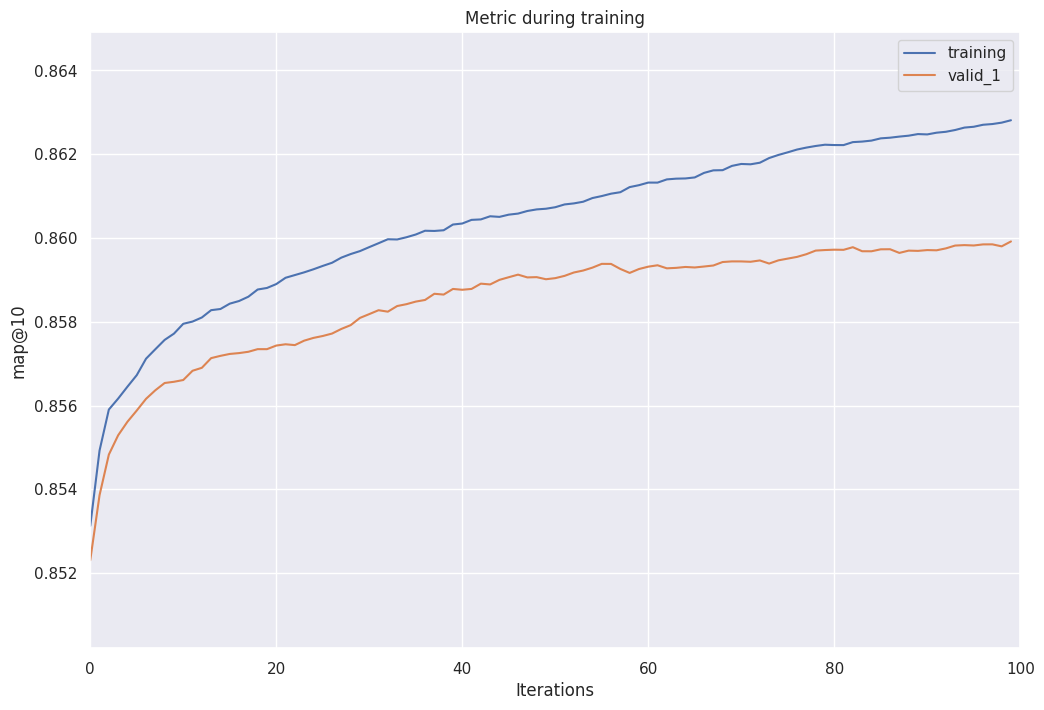

In [18]:
lgb.plot_metric(gbm, figsize = (12,8))

In [118]:
# gbm.booster_.save_model('ColdStart/back/files/lgbr_v1.txt')

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

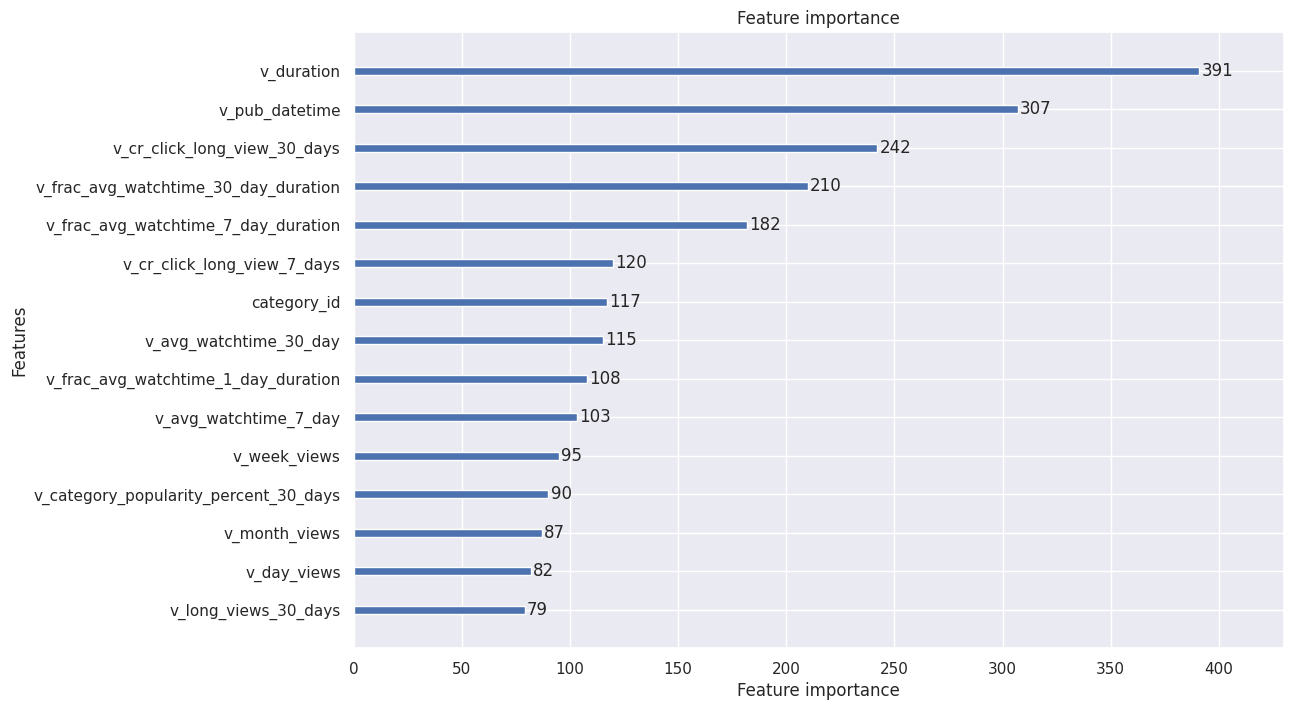

In [19]:
lgb.plot_importance(gbm, figsize = (12,8), max_num_features=15)

# Матрица схожести видео

Следующий этап это матрица схожести видео при помощи tfidf

In [8]:
df_video = df_video[df_video['v_pub_datetime'] > df_video['v_pub_datetime'].min()]

In [9]:
df_video = df_video[df_video['v_duration'] != 0]

In [10]:
df_video['novelity'] = (df_video['v_pub_datetime'] - df_video['v_pub_datetime'].max()).dt.days

In [11]:
num_f = df_video.columns.drop(['video_id', 'v_pub_datetime', 'row_number', 'title', 'description', 'category_id', 'author_id', 'v_is_deleted', 'v_is_hidden']).sort_values()
num_f

Index(['novelity', 'v_avg_watchtime_1_day', 'v_avg_watchtime_30_day',
       'v_avg_watchtime_7_day', 'v_category_popularity_percent_30_days',
       'v_category_popularity_percent_7_days', 'v_cr_click_comment_1_days',
       'v_cr_click_comment_30_days', 'v_cr_click_comment_7_days',
       'v_cr_click_dislike_1_days', 'v_cr_click_dislike_30_days',
       'v_cr_click_dislike_7_days', 'v_cr_click_like_1_days',
       'v_cr_click_like_30_days', 'v_cr_click_like_7_days',
       'v_cr_click_long_view_1_days', 'v_cr_click_long_view_30_days',
       'v_cr_click_long_view_7_days', 'v_cr_click_vtop_1_days',
       'v_cr_click_vtop_30_days', 'v_cr_click_vtop_7_days', 'v_day_views',
       'v_dislikes', 'v_duration', 'v_frac_avg_watchtime_1_day_duration',
       'v_frac_avg_watchtime_30_day_duration',
       'v_frac_avg_watchtime_7_day_duration', 'v_likes', 'v_long_views_1_days',
       'v_long_views_30_days', 'v_long_views_7_days', 'v_month_views',
       'v_total_comments', 'v_week_views', 'v_

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(df_video[num_f])

In [13]:
df_video_z = pd.DataFrame(scaler.transform(df_video[num_f]), columns=num_f, index=df_video.index)
df_video_z.describe().T

,count,mean,std,min,25%,50%,75%,max
novelity,274938.0,4.496812e-17,1.000002,-7.798123,-0.156953,0.357230,0.538784,0.737565
v_avg_watchtime_1_day,274938.0,-1.815523e-18,1.000002,-0.031330,-0.029666,-0.019524,0.011728,492.069120
v_avg_watchtime_30_day,274938.0,-3.572898e-18,1.000002,-0.053784,-0.044522,-0.026869,0.018277,497.918471
v_avg_watchtime_7_day,274938.0,-9.355435e-18,1.000002,-0.092200,-0.077965,-0.046642,0.036309,261.794606
v_category_popularity_percent_30_days,274938.0,-1.237398e-16,1.000002,-1.112144,-0.772298,-0.288232,0.544395,3.254351
v_category_popularity_percent_7_days,274938.0,2.647433e-16,1.000002,-1.145276,-0.796936,-0.152982,0.450211,4.055074
v_cr_click_comment_1_days,274938.0,1.330953e-18,1.000002,-0.010283,-0.010283,-0.010283,-0.010283,244.050602
v_cr_click_comment_30_days,274938.0,1.612650e-17,1.000002,-0.108041,-0.108041,-0.108041,-0.108041,135.227884
v_cr_click_comment_7_days,274938.0,-1.033750e-18,1.000002,-0.057596,-0.057596,-0.057596,-0.057596,174.541829
v_cr_click_dislike_1_days,274938.0,-8.399217e-19,1.000002,-0.002739,-0.002739,-0.002739,-0.002739,518.371451


In [14]:
from sklearn.cluster import KMeans, DBSCAN, MeanShift

kmeans = KMeans(n_clusters=6, random_state=44, n_init="auto", init='k-means++').fit(df_video_z[num_f])

In [15]:
df_video_z['label'] = kmeans.labels_

In [16]:
result_df = pd.DataFrame()

for label in range(6):
    subset = df_video_z[df_video_z['label'] == label].head(1000)
    result_df = pd.concat([result_df, subset])

result_df.shape

(4026, 36)

In [17]:
%%time
from razdel import tokenize
import nltk
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('russian'))
morph = MorphAnalyzer()

def preprocess(text):
    tokens = [t.text for t in tokenize(text.lower())]
#     filtered_tokens = [morph.parse(word)[0].normal_form for word in tokens if word.isalnum() and word not in stop_words]
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

# df_video['description_norm'] = df_video['description'].apply(preprocess)
df_video['title_norm'] = df_video['title'].apply(preprocess)

[nltk_data] Downloading package punkt to /home/user1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/user1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CPU times: user 15.6 s, sys: 80.7 ms, total: 15.7 s
Wall time: 16.3 s


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [19]:
%%time
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0.0)
tfidf_matrix = tf.fit_transform(df_video['title_norm'])

CPU times: user 2.22 s, sys: 24.7 ms, total: 2.24 s
Wall time: 2.25 s


In [ ]:
df_video_cat = pd.get_dummies(df_video, columns = ['category_id'])

df_video_cat = df_video_cat.drop(columns=['author_id', 'v_pub_datetime', 'description', 
                                          'title', 'row_number', 'v_is_hidden', 'v_is_deleted', 'video_id', 'title_norm'])

df_video_cat.iloc[:, 34:] = df_video_cat.iloc[:, 34:].astype(np.uint64)

In [21]:
for col in result_df.columns:
    df_video[col] = result_df[col]

In [ ]:
from scipy.sparse import csr_matrix, hstack

print(df_video_cat.values.shape)
print(tfidf_matrix.shape)
dense_csr = csr_matrix(df_video_cat.values)

# Объединение матриц по столбцам
combined_csr = hstack([tfidf_matrix, dense_csr])
print(combined_csr.shape)

(274938, 75)
(274938, 146659)


In [ ]:
%%time
linear_sim = linear_kernel(tfidf_matrix, tfidf_matrix, dense_output=False)

In [ ]:
from scipy.sparse import save_npz, load_npz

save_npz('ColdStart/back/files/video_csr_matrix.npz', linear_sim)

In [ ]:
!ls ColdStart/back/files/ -lah

In [78]:
new_ids = pd.Series(df_video.index, index=df_video['video_id'])

In [79]:
df_video = df_video.reset_index()
titles = df_video['title']
indices = pd.Series(df_video.index, index=df_video['title'])

In [80]:
indices.index[:4]

Index(['найк', 'Фиорентина - Ювентус. Обзор матча 21.05.2022',
       'Нидерланды - Ирландия. Обзор отборочного матча Чемпионата Европы-2024 18.11.2023',
       'МУЖИК на К700 поспорил с ВНЕДОРОЖНИКАМИ и УАЗ ЕРМАК ! ЭКСТРЕМАЛЬНЫЙ OFFROAD'],
      dtype='object', name='title')

In [83]:
def get_recommendations(title):
    idx = indices[title]
    print(idx)
    sim_scores = []
    row = linear_sim.getrow(idx)
    for i in range(len(row.indices)):
        sim_scores.append((row.indices[i], row.data[i]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [84]:
get_recommendations('Лучше звоните Солу  – 1 сезон 1 серия / Better Call Saul').head(10)

1166


12763    Лучше звоните Солу  – 3 сезон 8 серия / Better...
11499    Лучше звоните Солу  – 5 сезон 4 серия / Better...
10516    Лучше звоните Солу  – 5 сезон 5 серия / Better...
1166     Лучше звоните Солу  – 1 сезон 1 серия / Better...
7479     Лучше звоните Солу  – 6 сезон 10 серия / Bette...
3308     Лучше звоните Солу  – 4 сезон 10 серия / Bette...
10464    Лучше звоните Солу 2 сезон 2 серия «Пирог» (се...
2492     Лучше звоните Солу 3 сезон 4 серия «Сабросито»...
4227     Лучше звоните Солу 2 сезон 1 серия «Выключател...
14650                                  Ты 1 сезон, 1 серия
Name: title, dtype: object

In [90]:
from scipy.sparse import csr_matrix, csr_array

def get_rec2(rating_vec, title, csr):
    idx = indices[title]
    print(idx)
    rating_vec.iloc[:, idx] = 1
    res = csr_array(rating_vec.values).dot(csr).toarray().flatten()
    top_similar = pd.Series(res.argsort()[-100:][::-1])
    return titles.iloc[top_similar]

In [86]:
user = pd.DataFrame(0, columns=df_video['video_id'], index=[0])
user

video_id,3,12,27,34,38,40,43,45,47,50,...,142873,142891,142898,142923,142925,142932,142934,142944,142955,142957
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
get_rec2(user, 'Лучше звоните Солу  – 1 сезон 1 серия / Better Call Saul', linear_sim).head(10)

1166


1166     Лучше звоните Солу  – 1 сезон 1 серия / Better...
10516    Лучше звоните Солу  – 5 сезон 5 серия / Better...
12763    Лучше звоните Солу  – 3 сезон 8 серия / Better...
13076    Лучше звоните Солу  – 3 сезон 2 серия / Better...
11499    Лучше звоните Солу  – 5 сезон 4 серия / Better...
7479     Лучше звоните Солу  – 6 сезон 10 серия / Bette...
3308     Лучше звоните Солу  – 4 сезон 10 серия / Bette...
10464    Лучше звоните Солу 2 сезон 2 серия «Пирог» (се...
2492     Лучше звоните Солу 3 сезон 4 серия «Сабросито»...
4227     Лучше звоните Солу 2 сезон 1 серия «Выключател...
Name: title, dtype: object

In [39]:
df_video['video_id'] = df_video['index']
df_video = df_video.drop(columns=['index', 'title_norm'])
df_video

,video_id,v_pub_datetime,v_total_comments,v_year_views,v_month_views,v_week_views,v_day_views,v_likes,v_dislikes,v_duration,...,v_category_popularity_percent_7_days,v_category_popularity_percent_30_days,v_long_views_1_days,v_long_views_7_days,v_long_views_30_days,row_number,title,description,category_id,author_id
0,3,2010-01-01 00:00:01+03:00,0,10657,5227,1300,202,24,0,42.025,...,0.418336,0.513562,186,1162,4550,1,найк,найк дрессура,Животные,4af9b043-40f4-4288-85c6-192612dca35b
1,12,2022-05-21 21:39:29+03:00,0,6245,750,235,41,3,0,280.729,...,2.829045,1.885923,0,106,352,1,Фиорентина - Ювентус. Обзор матча 21.05.2022,Смотри лучший спортивный контент в одном месте...,Спорт,47df7ce6-53b1-48b3-a6fa-c0d72f2f1f01
2,27,2023-11-19 01:33:50+03:00,12,26241,1875,362,51,48,2,365.889,...,8.825809,9.250835,0,116,641,1,Нидерланды - Ирландия. Обзор отборочного матча...,?? Смотри лучший спортивный контент в одном ме...,Лайфстайл,47df7ce6-53b1-48b3-a6fa-c0d72f2f1f01
3,34,2022-12-29 14:00:24+03:00,1,335,8,1,0,1,0,3703.189,...,1.315121,1.368785,0,1,3,1,МУЖИК на К700 поспорил с ВНЕДОРОЖНИКАМИ и УАЗ ...,Купи CGPods для себя или в подарок - тут: ТО...,Авто-мото,2eb65d24-1075-4afc-915a-dd3fc7066292
4,38,2024-01-20 16:34:40+03:00,0,8670,3655,1013,147,21,0,1352.289,...,9.304933,8.716591,99,692,2482,1,Рик и Морти / Rick and Morty – 2 сезон 8 серия,Джерри подхватывает инопланетный вирус по вине...,Сериалы,ef701a99-ed7d-4f0a-9cc3-bdf99932a56c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,142932,2022-04-22 11:11:12+03:00,0,704,56,11,1,1,0,330.006,...,1.467654,1.711370,0,8,41,1,"Дракоша Тоша | 1 сезон, 25 выпуск | Погода на ...","Вот была бы такая кнопка, чтобы включать такую...",Детям,0f0c7ef3-1d67-499a-b528-43232c4cfe5b
14996,142934,2024-05-16 14:08:43+03:00,0,159,134,112,29,0,0,1991.251,...,7.296065,6.321241,0,47,61,1,Lucy на русском | Бедная Папа vs Богатая Мама ...,Lucy на русском | Бедная Папа vs Богатая Мама ...,Разное,e4f52a54-f655-4916-8631-db386f76ff77
14997,142944,2022-05-24 14:41:44+03:00,1,500,44,10,1,0,0,2145.292,...,4.687632,4.424202,0,2,3,1,ТОП-15 ЛУЧШИХ ФИЛЬМОВ MARVEL.mp4,"топ лучших фильмов, топ лучших фильмов 2021, т...",Фильмы,41eae9f2-f3ed-473c-a33f-b19a1f7d8f71
14998,142955,2023-07-31 11:05:29+03:00,0,135,109,103,22,3,0,7291.624,...,3.497065,2.705233,0,16,18,1,Релакс Море Кофе Музыка Джаз,Релакс,Музыка,ba90547c-6510-4251-97ef-0557541044a9


In [ ]:
df_video.to_parquet('ColdStart/back/files/mvp_movie.parquet')